# Text Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix

**Data Understanding, Analysis and Cleaning**
Understand what is data about, Perform a basic data cleaning:<br>
Some example data cleaning tasks may be:<br>
• Removing Unwanted Text.<br>
• Removing Unwanted Characters and words.<br>
• Normalizing Text data.<br>
• Padding and Tokenizations if applied.




In [ ]:
# Load the training dataset from a CSV file and display the first few rows
df_train = pd.read_csv("/content/drive/MyDrive/Classroom/Artificial_Intelligence_and_Machine_Learning/Coursework AI/Twitter Sentimental Analysis/twitter_training.csv",
                       header=None,
                       names=['Tweet-ID', 'Entity', 'Sentiment', 'Tweet-Content'])
df_train.head()


,Tweet-ID,Entity,Sentiment,Tweet-Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df_train.shape

(74682, 4)

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Classroom/Artificial_Intelligence_and_Machine_Learning/Coursework AI/Twitter Sentimental Analysis/twitter_validation.csv", header=None, names=['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content'])
df_test.head()

,Tweet ID,Entity,Sentiment,Tweet Content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [ ]:
df_test.shape

(1000, 4)

In [ ]:
# Rename the columns of the training and test datasets for better readability
df_train.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
df_test.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']

In [ ]:
# Remove the 'Tweet ID' and 'Entity' columns from the training and test datasets
df_train.drop(columns=['Tweet ID', 'Entity'], inplace=True)
df_test.drop(columns=['Tweet ID', 'Entity'], inplace=True)

In [ ]:
# Check for missing values in the training and test datasets
df_train.isnull().sum()
df_test.isnull().sum()

Sentiment        0
Tweet Content    0
dtype: int64

In [ ]:
# Remove rows with any missing values in the training and test datasets
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [ ]:
# Check for duplicate rows in the training and test datasets
df_train.duplicated().sum()
df_test.duplicated().sum()

1

In [ ]:
#Drops the duplicated columns
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [ ]:
# Concatenate the training and test datasets into a single dataset
twitter_sentiments = pd.concat([df_train,df_test],ignore_index=True)
twitter_sentiments.shape

(70768, 2)

In [ ]:
#checks the total duplicated rows
twitter_sentiments.duplicated().sum()

516

In [ ]:
# Remove duplicate rows from the twitter_sentiments dataset
twitter_sentiments.drop_duplicates(inplace=True)

print("Number of duplicates in the twitter_sentiments:", twitter_sentiments.duplicated().sum())
twitter_sentiments.shape


Number of duplicates in the twitter_sentiments: 0


(70252, 2)

In [ ]:
twitter_sentiments['Tweet Content Length'] = twitter_sentiments['Tweet Content'].apply(len)
twitter_sentiments.head()


,Sentiment,Tweet Content,Tweet Content Length
0,Positive,im getting on borderlands and i will murder yo...,53
1,Positive,I am coming to the borders and I will kill you...,51
2,Positive,im getting on borderlands and i will kill you ...,50
3,Positive,im coming on borderlands and i will murder you...,51
4,Positive,im getting on borderlands 2 and i will murder ...,57


In [ ]:
twitter_sentiments.iloc[:5]

,Sentiment,Tweet Content,Tweet Content Length
0,Positive,im getting on borderlands and i will murder yo...,53
1,Positive,I am coming to the borders and I will kill you...,51
2,Positive,im getting on borderlands and i will kill you ...,50
3,Positive,im coming on borderlands and i will murder you...,51
4,Positive,im getting on borderlands 2 and i will murder ...,57


In [ ]:
print(f"Sentiment value count: \n {twitter_sentiments['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Negative      21329
Positive      19271
Neutral       17281
Irrelevant    12371
Name: count, dtype: int64


In [ ]:
twitter_sentiments['Sentiment'] = twitter_sentiments['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {twitter_sentiments['Sentiment'].value_counts()}")


Sentiment value count: 
 Sentiment
Neutral     29652
Negative    21329
Positive    19271
Name: count, dtype: int64


In [ ]:
# Count the number of occurrences of each sentiment value in the twitter_sentiments dataset
sentiments = twitter_sentiments['Sentiment'].value_counts()
labels = sentiments.index
sizes = sentiments.values
colors = ['#FF5733', '#33FF57', '#3366FF']
# Define the explode value for each segment of the pie chart
explode = (0.01, 0, 0)

In [ ]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = remove_special_characters_and_emojis(text)
    text = remove_urls(text)
    text = remove_mentions_and_hashtags(text)
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespaces(text)
    text = tokenize_and_lemmatize(text)
    return text

In [ ]:
def remove_urls(text: str) -> str:
    return re.sub(r'https*\S+', ' ', text)

In [ ]:
def remove_mentions_and_hashtags(text: str) -> str:
    return re.sub(r'[@#]\S+', ' ', text)

In [ ]:
def remove_html_tags(text: str) -> str:
    return re.sub('<.*?>', '', text)

In [ ]:
def expand_contractions(text: str) -> str:
    contractions = {"don't": 'do not', "can't": 'cannot'}
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text

In [ ]:
def remove_punctuation(text: str) -> str:
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)

In [ ]:
def remove_extra_whitespaces(text: str) -> str:
    return re.sub('\s{2,}', ' ', text)

In [ ]:
def remove_special_characters_and_emojis(text: str) -> str:
    special_char_pattern = r'[^a-zA-Z0-9\s]|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]'

    return re.sub(special_char_pattern, '', text)

In [ ]:
def tokenize_and_lemmatize(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_set]
    return ' '.join(lemmatized_words)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Apply the 'clean_text' function to the 'Tweet Content' column of the training dataframe
df_train['cleaned_tweet'] = df_train['Tweet Content'].apply(clean_text)
df_test['cleaned_tweet'] = df_test['Tweet Content'].apply(clean_text)

In [ ]:
# Convert certain sentiment labels to 'Neutral' if they are 'Neutral' or 'Irrelevant'
df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_train['Sentiment'].value_counts()}")

# Convert certain sentiment labels to 'Neutral' if they are 'Neutral' or 'Irrelevant'
df_test['Sentiment'] = df_test['Sentiment'].apply(lambda x: 'Neutral' if x.lower() in ['neutral', 'irrelevant'] else x)
print(f"Sentiment value count: \n {df_test['Sentiment'].value_counts()}")

Sentiment value count: 
 Sentiment
Neutral     29394
Negative    21237
Positive    19138
Name: count, dtype: int64
Sentiment value count: 
 Sentiment
Neutral     457
Positive    276
Negative    266
Name: count, dtype: int64


**Showing the word cloud of the dataset**

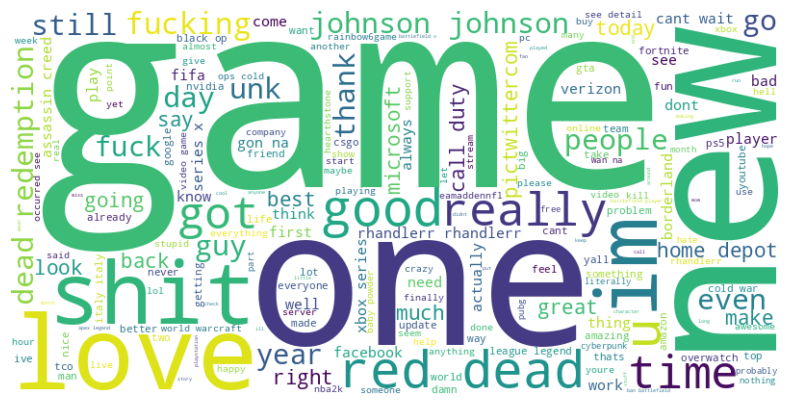

In [ ]:
from wordcloud import WordCloud
# Concatenate all tweets into a single string
text = ' '.join(df_train['cleaned_tweet'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

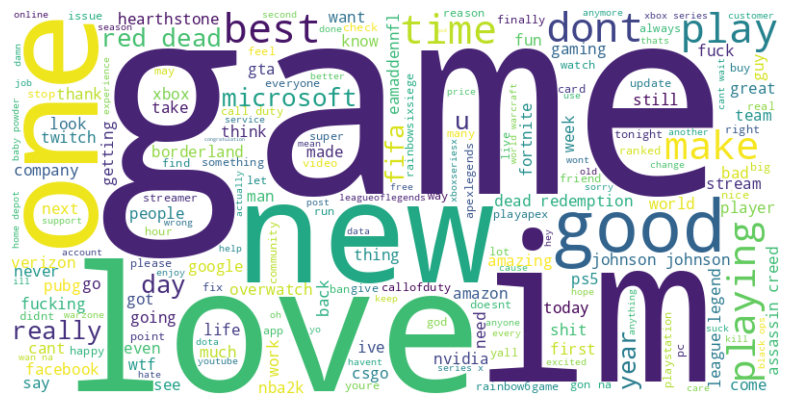

In [ ]:
# Concatenate all tweets into a single string
text = ' '.join(df_test['cleaned_tweet'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
label_encoder = LabelEncoder()

# Fit the LabelEncoder object to the 'Sentiment' column of the training dataframe and transform it to encoded values
df_train['encoded_sentiment'] = label_encoder.fit_transform(df_train['Sentiment'])
df_test['encoded_sentiment'] = label_encoder.transform(df_test['Sentiment'])

In [ ]:
twitter_sentiments = pd.concat([df_train['cleaned_tweet'], df_test['cleaned_tweet']])

# Tokenize tweets for Word2Vec
tokenized_tweets = [tweet.split() for tweet in twitter_sentiments]

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, sample=1e-3, epochs=10)

**Build Model:** <br>
You must build a RNN based deep sequential model which contains:<br>

• Embedding layer-for character/word embedding.<br>
• One encoder with (LSTM/GRU cells) RNN which encodes the input character sequence.<br>
• One dense (linear) Classifier layer that can perform text classifications.

In [ ]:
# Fit the Tokenizer object to the cleaned tweets in the combined training and testing dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(twitter_sentiments)

# Convert the cleaned tweets in the training dataset to sequences of integers
train_sequences = tokenizer.texts_to_sequences(df_train['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])


# Pad the sequences to a fixed length of 100
X_train = pad_sequences(train_sequences, maxlen=100)
X_test = pad_sequences(test_sequences, maxlen=100)

# Extract the encoded sentiment labels from the training and testing datasets
y_train = df_train['encoded_sentiment']
y_test = df_test['encoded_sentiment']

**Training of the Model:**<br>
Once the model is built, Train your model for as many epochs you think is necessary.<br>
Please, Plot and show training loss/validation loss behaviour for each iterations.<br>
We suggest you to use Google Colab and make use of its GPU for training.

In [ ]:
model = Sequential()
# Add an Embedding layer with vocabulary size equal to the number of unique tokens + 1 and output dimensionality of 100
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))

# Add a LSTM layer with 128 units and return sequences
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))

# Add a Dense output layer with 3 units and softmax activation function for multiclass classification
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3782100   
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 4031319 (15.38 MB)
Trainable params: 4031319 (15.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

Epoch 1/15
437/437 [==============================] - 59s 122ms/step - loss: 0.6500 - accuracy: 0.7132 - val_loss: 1.2263 - val_accuracy: 0.5414
Epoch 2/15
437/437 [==============================] - 15s 35ms/step - loss: 0.2536 - accuracy: 0.9021 - val_loss: 1.6828 - val_accuracy: 0.5271
Epoch 3/15
437/437 [==============================] - 11s 25ms/step - loss: 0.1506 - accuracy: 0.9428 - val_loss: 1.8608 - val_accuracy: 0.5222
Epoch 4/15
437/437 [==============================] - 10s 23ms/step - loss: 0.1116 - accuracy: 0.9564 - val_loss: 2.3834 - val_accuracy: 0.5128
Epoch 5/15
437/437 [==============================] - 9s 20ms/step - loss: 0.0888 - accuracy: 0.9657 - val_loss: 2.5969 - val_accuracy: 0.5118
Epoch 6/15
437/437 [==============================] - 8s 18ms/step - loss: 0.0738 - accuracy: 0.9707 - val_loss: 2.6958 - val_accuracy: 0.5040
Epoch 7/15
437/437 [==============================] - 9s 20ms/step - loss: 0.0664 - accuracy: 0.9740 - val_loss: 2.9272 - val_accuracy: 0

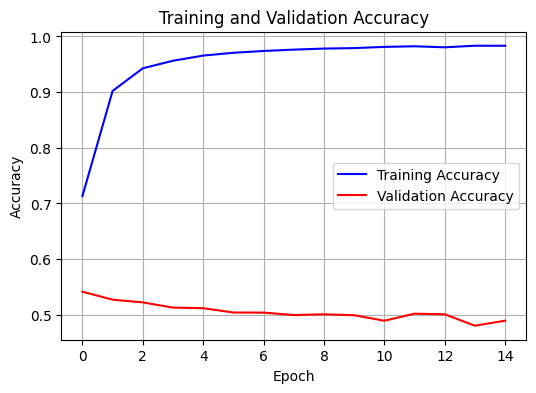

In [ ]:
# Plotting training and validation accuracy over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



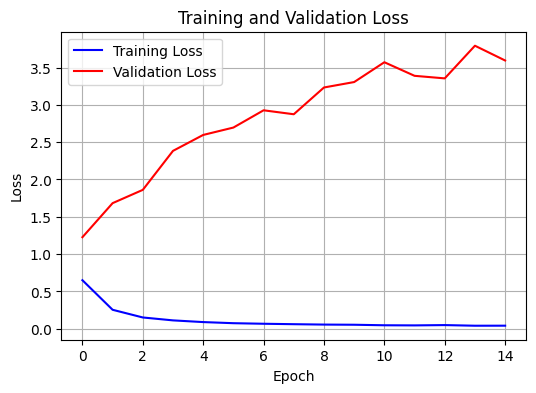

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate the model:**<br>
Pick appropriate evaluation metrics to evaluate your model.

***Sentiment analysis***, where the task is to classify the sentiment of text data (e.g., tweets) into categories such as positive, negative, or neutral or irrevlant you can use the following evaluation metrics:

**Accuracy**: Overall percentage of correctly classified instances out of all instances.<br>

**Precision**: Proportion of true positive predictions for a specific sentiment class out of all predictions for that class. It measures the model's ability to avoid false positives.<br>

**Recall**: Proportion of true positive predictions for a specific sentiment class out of all actual instances of that class. It measures the model's ability to capture all instances of the class.<br>

**F1 Score**: Harmonic mean of precision and recall for a specific sentiment class. It balances both precision and recall.

In [ ]:
# Evaluate the performance of the trained model on the test dataset
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 [==============================] - 0s 5ms/step - loss: 0.9101 - accuracy: 0.8669
Test Loss: 0.9101102948188782
Test Accuracy: 0.8668668866157532


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Make predictions on the test dataset using the trained model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
report = classification_report(y_true_classes, y_pred_classes)

# Print the evaluation metrics to the console
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)

32/32 [==============================] - 1s 4ms/step
Accuracy: 0.8668668668668669
Precision: 0.8670019567065221
Recall: 0.8668668668668669
F1 Score: 0.8668649335316002

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       266
           1       0.88      0.88      0.88       457
           2       0.85      0.88      0.86       276

    accuracy                           0.87       999
   macro avg       0.86      0.86      0.86       999
weighted avg       0.87      0.87      0.87       999



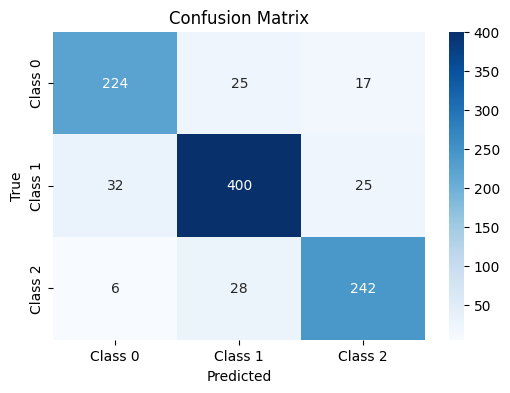

In [ ]:
# Generate a confusion matrix for the predicted and true classes
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 4))
# Plot the confusion matrix using seaborn heatmap function
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The outcomes of the sentiment analysis will be presented in the form of the model's performance in the light of the evaluation metrics that were calculated in the previous step. Here's how you can interpret the results:Here's how you can interpret the results:

**Accuracy:** Accuracy mean and represent the degree of correctness of the model predictions. When the accuracy is high, the effectiveness of a model is better. Still, accuracy may not be the only measure, and it is possible that the classes are imbalanced.

**Precision:** Similarly, precision measures the accuracy of the model which is the amount of true positive predictions to all the positive predictions it makes. This means that the model fewer false-positive predictions makes.

**Recall:** The recall is the ratio of the true positive results to the number of the actual positive instances in the dataset. The high recall of the model proves that it has captured nearly all the instances of positivity.

**F1 Score:** F1 score is the harmonic the mean of precision and recall. It gives a compromise between accuracy and total number of retrieved documents. A higher value of F1 score means there is an better overall performance.

Referring these metrics the model performance will be estimated during classification task of the sentiment in the dataset. For instance, if the accuracy, precision, recall, and F1 score are high, it means that the model is doing well in classifying sentiment.

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(df_test['cleaned_tweet'])

# Define and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_vectorized, df_test['Sentiment'])

# Make predictions on test cases from the dataset
predictions = model.predict(X_vectorized)

# Print predictions along with corresponding test cases
for i, (tweet, prediction) in enumerate(zip(df_test['cleaned_tweet'], predictions)):
    print("Test Case {}: Prediction - {}".format(i+1, prediction))
    print("Test Case Text:", tweet)
    print()


Test Case 1: Prediction - Neutral
Test Case Text: mentioned facebook struggling motivation go run day translated tom great auntie hayley cant get bed told grandma think im lazy terrible person

Test Case 2: Prediction - Neutral
Test Case Text: bbc news amazon bos jeff bezos reject claim company acted like drug dealer bbccouknewsavbusine

Test Case 3: Prediction - Negative
Test Case Text: microsoft pay word function poorly samsungus chromebook

Test Case 4: Prediction - Negative
Test Case Text: csgo matchmaking full closet hacking truly awful game

Test Case 5: Prediction - Neutral
Test Case Text: president slapping american face really commit unlawful act acquittal discover google vanityfaircomnews202002t

Test Case 6: Prediction - Negative
Test Case Text: hi eahelp ive madeleine mccann cellar past 13 year little sneaky thing escaped whilst loading fifa point took card im use paypal account isnt working help resolve please

Test Case 7: Prediction - Positive
Test Case Text: thank eamad